## Цель ноутбука: изучение метода Few Shots Learning

#### В RTSD не хватает 14 знаков:

| Знак | Описание | Источник |
| ------------- | ------------- | ---- |
| 1.6 | Пересечение равнозначных дорог | - |
| 1.31 | Туннель | - |
| 2.4 | Уступите дорогу | GTSRB Recognition |
| 3.21 | Конец запрещения обгона | GTSRB Recognition |
| 3.22 | Обгон грузовым автомобилям запрещен | GTSRB Recognition |
| 3.23 | Конец запрещения обгона грузовым автомобилям | GTSRB Recognition |
| 3.24-90 | Огр 90 | - |
| 3.24-100 | Огр 100 | GTSRB Recognition |
| 3.24-110 | Огр 110 | - |
| 3.24-120 | Огр 120 | GTSRB Recognition |
| 3.24-130 | Огр 130 | - |
| 3.25 | Конец огр. максимальной скорости | GTSRB Recognition |
| 3.31 | Конец всех ограничений | GTSRB Recognition |
| 6.3.2 | Зона для разворота | - |

Инициализация библиотек

In [9]:
import albumentations as A
if A.__version__ != '1.0.3':
    !pip install albumentations==1.0.3
    !pip install opencv-python-headless==4.5.2.52
    assert False, 'restart runtime pls'

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn
import seaborn as sns
import pandas as pd
import os
import pathlib
import shutil
import cv2
import PIL
import cv2
import sys
from datetime import datetime

TEXT_COLOR = 'black'
# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
%matplotlib inline
plt.rcParams["figure.figsize"] = (17,10)

IN_COLAB = False
USE_COLAB_GPU = False

try:
    import google.colab
    IN_COLAB = True
    USE_COLAB_GPU = True
    from google.colab import drive
except:
    if IN_COLAB:
        print('[!]YOU ARE IN COLAB, BUT DIDNT MOUND A DRIVE. Model wont be synced[!]')

        if not os.path.isfile(CURRENT_FILE_NAME):
            print("FIX ME")
        IN_COLAB = False

    else:
        pass

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Инициализация основных путей и папки src

In [10]:
if not IN_COLAB:
    PROJECT_ROOT = pathlib.Path(os.path.join(os.curdir, os.pardir))
else:
    PROJECT_ROOT = pathlib.Path('..')
    
DATA_DIR = PROJECT_ROOT / 'data'
NOTEBOOKS_DIR = PROJECT_ROOT / 'notebooks'

SRC_DIR = PROJECT_ROOT / 'src'
sys.path.append(SRC_DIR)

In [14]:
STOCK_SIGNS_CSV_LOCATION = DATA_DIR / 'STOCK_SIGNS.csv'
STOCK_SIGNS_DATAFRAME = pd.read_csv(STOCK_SIGNS_CSV_LOCATION)

# Исправляем пешеходов в разные стороны
STOCK_SIGNS_DATAFRAME.loc[STOCK_SIGNS_DATAFRAME['SIGN'] == '5.19.2', 'SIGN'] = '5.19.1'

from sklearn import preprocessing

# кодируем знаки, добавляем еще колонку
LE_LOCATION = DATA_DIR / 'STOCK_SIGNS_LE.npy'
le = preprocessing.LabelEncoder()

if os.path.isfile(LE_LOCATION):
    le.classes_ = np.load(LE_LOCATION, allow_pickle=True)
    print('[+] label encoder was restored')
else:
    le.fit_transform(STOCK_SIGNS_DATAFRAME['SIGN'])
    np.save(LE_LOCATION, le.classes_)
    print('[!] label encoder was created')
    
STOCK_SIGNS_DATAFRAME['ENCODED_LABELS'] = le.transform(STOCK_SIGNS_DATAFRAME['SIGN'])
STOCK_SIGNS_DATAFRAME['filepath'] = STOCK_SIGNS_DATAFRAME['filepath'].apply(lambda x: str(x).replace('\\', '/'))
STOCK_SIGNS_DATAFRAME['filepath'] = STOCK_SIGNS_DATAFRAME['filepath'].apply(lambda x: DATA_DIR / x)
STOCK_SIGNS_DATAFRAME[::6]

[+] label encoder was restored


,filepath,SIGN,ENCODED_LABELS
0,..\data\STOCK_SIGNS\1.1.png,1.1,0
6,..\data\STOCK_SIGNS\2.1.png,2.1,6
12,..\data\STOCK_SIGNS\3.18.1.png,3.18.1,12
18,..\data\STOCK_SIGNS\3.24.100.png,3.24.100,18
24,..\data\STOCK_SIGNS\3.24.40.png,3.24.40,24
30,..\data\STOCK_SIGNS\3.25.10.png,3.25.10,30
36,..\data\STOCK_SIGNS\3.25.30.png,3.25.30,36
42,..\data\STOCK_SIGNS\3.25.90.png,3.25.90,42
48,..\data\STOCK_SIGNS\5.16.png,5.16,48
54,..\data\STOCK_SIGNS\6.3.2.png,6.3.2,53


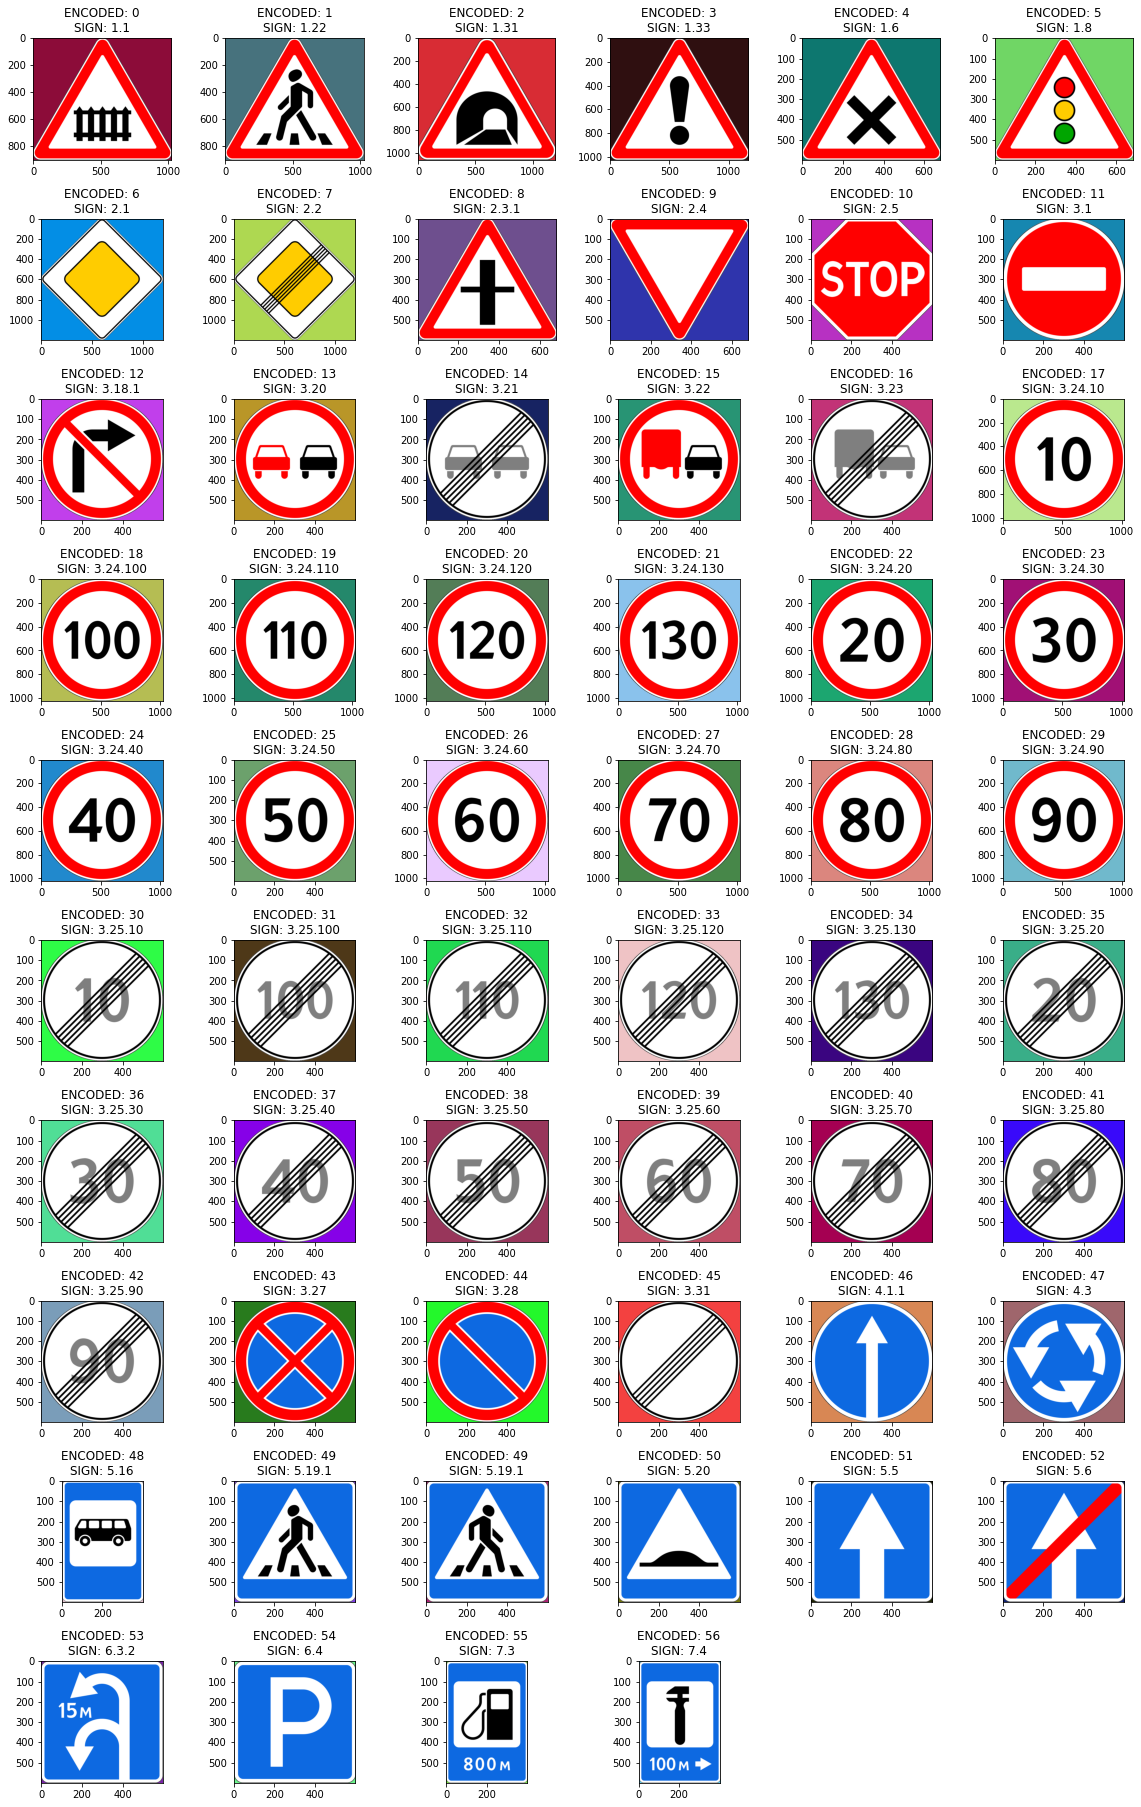

In [15]:
SIGN_LIST = list(STOCK_SIGNS_DATAFRAME['SIGN'])

nrows, ncols = 20, 6
fig = plt.figure(figsize = (16,50))

for idx, row in enumerate(STOCK_SIGNS_DATAFRAME.iterrows()):
    instance = row[1]
    path = str(instance['filepath'])
    sign = instance['SIGN']
    encoded_label = instance['ENCODED_LABELS']
    
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    trans_mask = img[:,:,3] == 0
    img[trans_mask] = [random.randrange(0, 256), random.randrange(0, 256), random.randrange(0, 256), 255]
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    ax = fig.add_subplot(nrows, ncols, idx+1)
    
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), aspect=1)
    ax.set_title('ENCODED: ' + str(encoded_label) 
                 + '\nSIGN: ' + str(sign)
                )
    
plt.tight_layout()